# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [2]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [3]:
def gini(x):
    p = np.unique(x, return_counts=True)[1] / len(x)
    return np.dot(p, 1-p)
    
def entropy(x):
    p = np.unique(x, return_counts=True)[1] / len(x)
    return -np.dot(p, np.log2(p))

def gain(left_y, right_y, criterion):
    node = np.concatenate((left_y, right_y))
    In = criterion(node)
    Il = criterion(left_y)
    Ir = criterion(right_y)
    len_l, len_r = len(left_y), len(right_y)
    len_t = len_l + len_r
    return len_t * In - len_l  * Il - len_r  * Ir 

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [4]:
class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

class DecisionTreeLeaf:
    def __init__(self, probs, size):
        self.probs = probs
        self.size = size
        self.y = max(probs, key=probs.get)

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [5]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        if criterion == "gini":
            self.criterion = gini
        elif criterion == "entropy":
            self.criterion = entropy
        else:
            raise ValueError(f"wrong criterion {criterion}")
            
    def make_node(self, ind, X, y, sort_ind, depth):
        def make_leaf():
            uni = np.unique(y)
            probs = dict(zip(uni, np.zeros(len(uni))))
            cur_uni, cnt = np.unique(y[ind], return_counts=True)
            probs2 = dict(zip(cur_uni, cnt/len(ind)))
            probs.update(probs2)
            return DecisionTreeLeaf(probs, len(ind))
        
        if (self.max_depth is not None and depth >= self.max_depth) or len(ind) < 2*self.min_samples_leaf or len(np.unique(y[ind])) == 1:
            return make_leaf()
        else:
            best_f = None
            best_s = None
            best_left = None
            best_right = None
            best_gain = None

            for k in range(X.shape[1]):
                res = -np.ones(X.shape[0], dtype=int)
                res[sort_ind[ind, k]] = ind
                res = res[res>=0]
                for val in range(1, len(res)):
                    if X[res[val-1], k] > X[res[val], k]:
                        raise NameError("lol")
                for j in range(len(ind)):
                    cur_left = res[:j+1]
                    cur_right = res[j+1:]
                    if (len(cur_left) >= self.min_samples_leaf and len(cur_right)>= self.min_samples_leaf) or len(cur_right) == 0:
                        cur_gain = gain(y[cur_left], y[cur_right], self.criterion)
                        if best_gain is None or cur_gain > best_gain:
                            best_f = k
                            best_s = X[res[j], k]
                            best_left = cur_left
                            best_right = cur_right
                            best_gain = cur_gain
            if len(best_right) == 0:
                return make_leaf()
            else:
                right_son = self.make_node(best_right, X, y, sort_ind, depth+1)
                left_son = self.make_node(best_left, X, y, sort_ind, depth+1)
                cur_node = DecisionTreeNode(best_f, best_s, left_son, right_son)
                return cur_node
                
            
    def fit(self, X, y):
        sort_ind = np.zeros(X.shape, dtype=int)
        for i in range(X.shape[1]):
            sort_ind[np.argsort(X[:,i]), i] = np.arange(X.shape[0]) 
        self.root = self.make_node(np.arange(X.shape[0]), X, y, sort_ind, 0)
    
    def query(self, x, full_res=False):
        cur_node = self.root
        history = []
        while not isinstance(cur_node, DecisionTreeLeaf):
            if x[cur_node.split_dim]  <= cur_node.split_value:
                if full_res:
                    history.append((cur_node.split_dim, cur_node.split_value,  "l"))
                cur_node = cur_node.left
            else:
                if full_res:
                    history.append((cur_node.split_dim, cur_node.split_value, "r"))
                cur_node = cur_node.right
        if full_res:
            return cur_node.probs, history
        return cur_node.probs

    def predict_proba(self, X, full_res=False):
        ans = []
        history = []
        for i in range(X.shape[0]):
            if full_res:
                to_ans, to_hist = self.query(X[i], full_res)
                ans.append(to_ans)
                history.append(to_hist)
            else:
                ans.append(self.query(X[i]))
        if full_res:
            return ans, history
        return ans
    
    def predict(self, X, full_res=False):
        if full_res:
            proba, hist = self.predict_proba(X, full_res)
        else:
            proba = self.predict_proba(X, full_res)
        if full_res:
             return [max(p.keys(), key=lambda k: p[k]) for p in proba], hist
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [6]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y, clmns=None):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1, clmns)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1, clmns)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        if clmns is None:
            node_name = f"x[{tree_root.split_dim}] <= {tree_root.split_value}"
        else:
            node_name = f"{clmns[tree_root.split_dim]} <= {tree_root.split_value:.5f}"
        plt.text(x_center, y, node_name,
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None, clmns = None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td, clmns)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [7]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

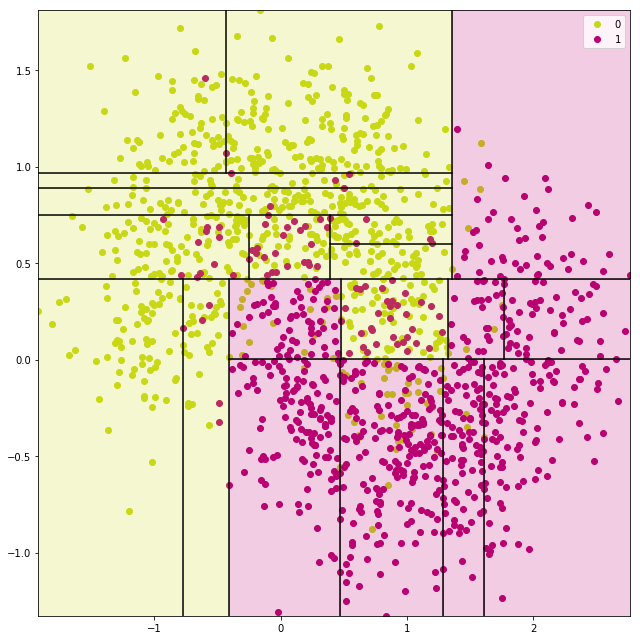

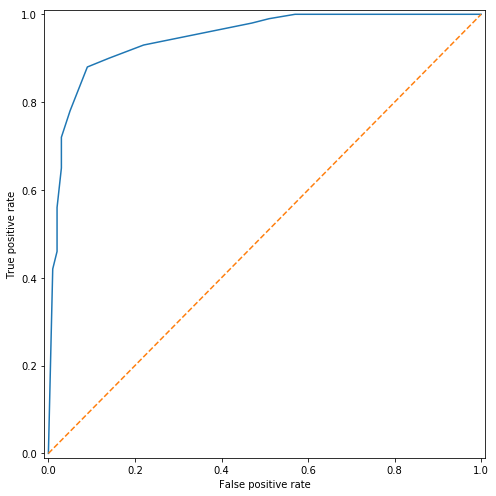

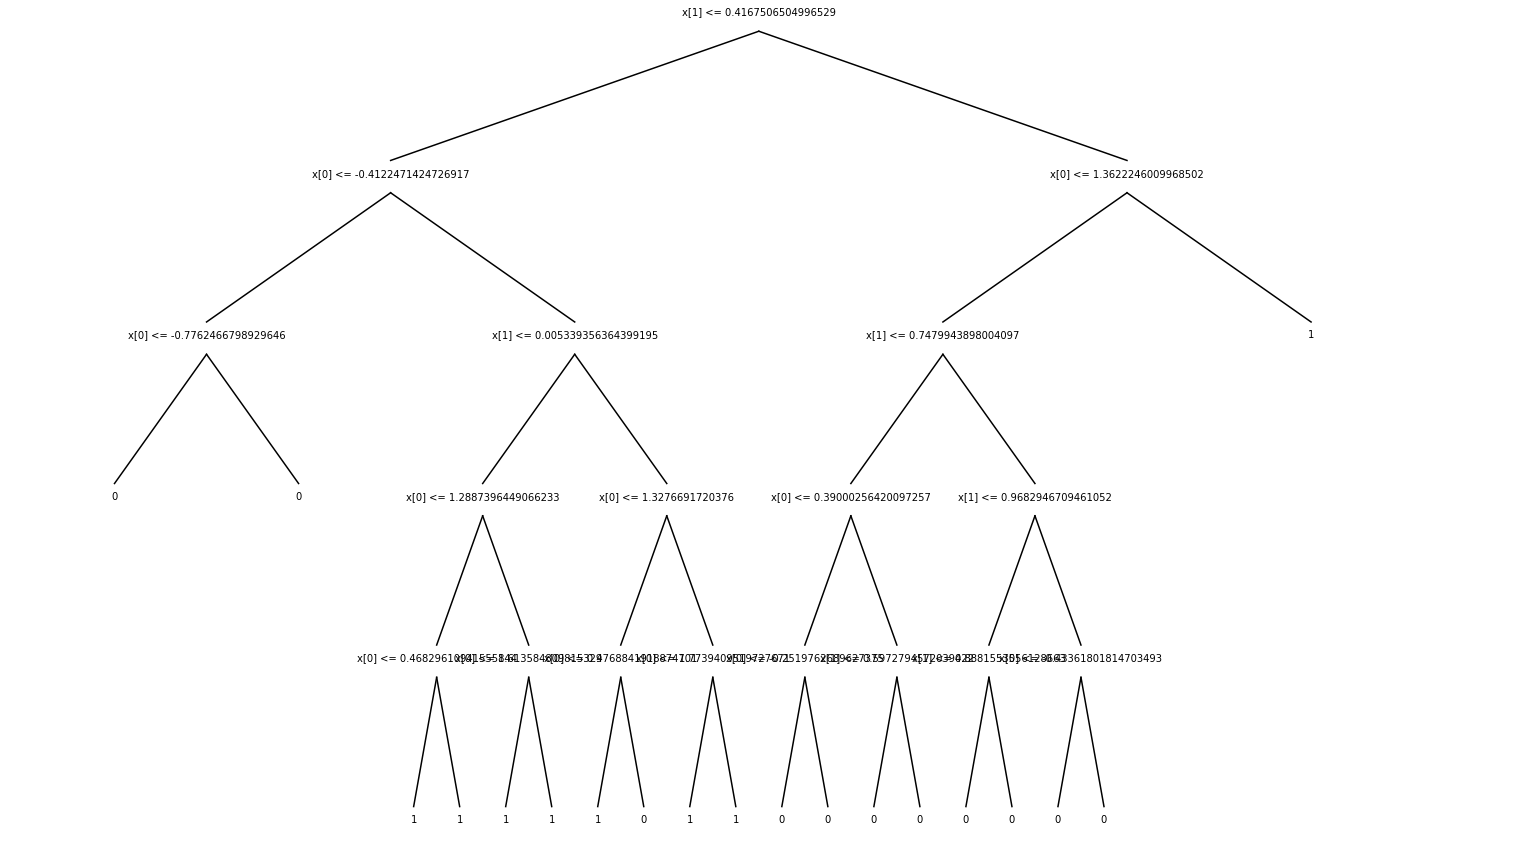

In [350]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

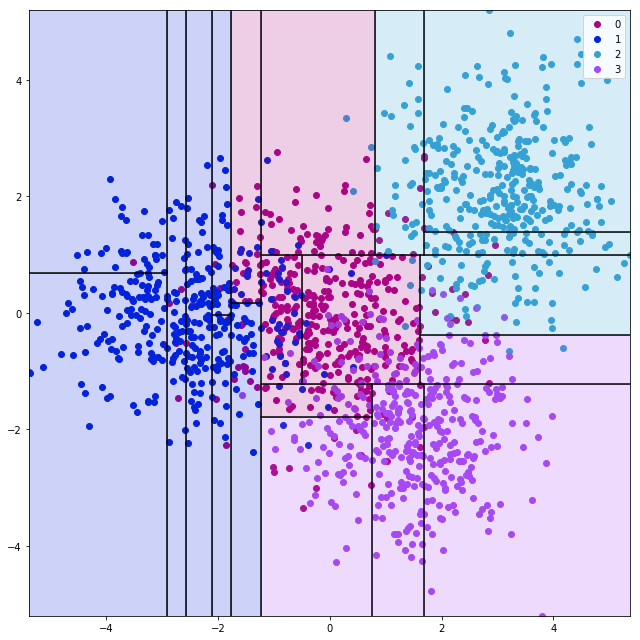

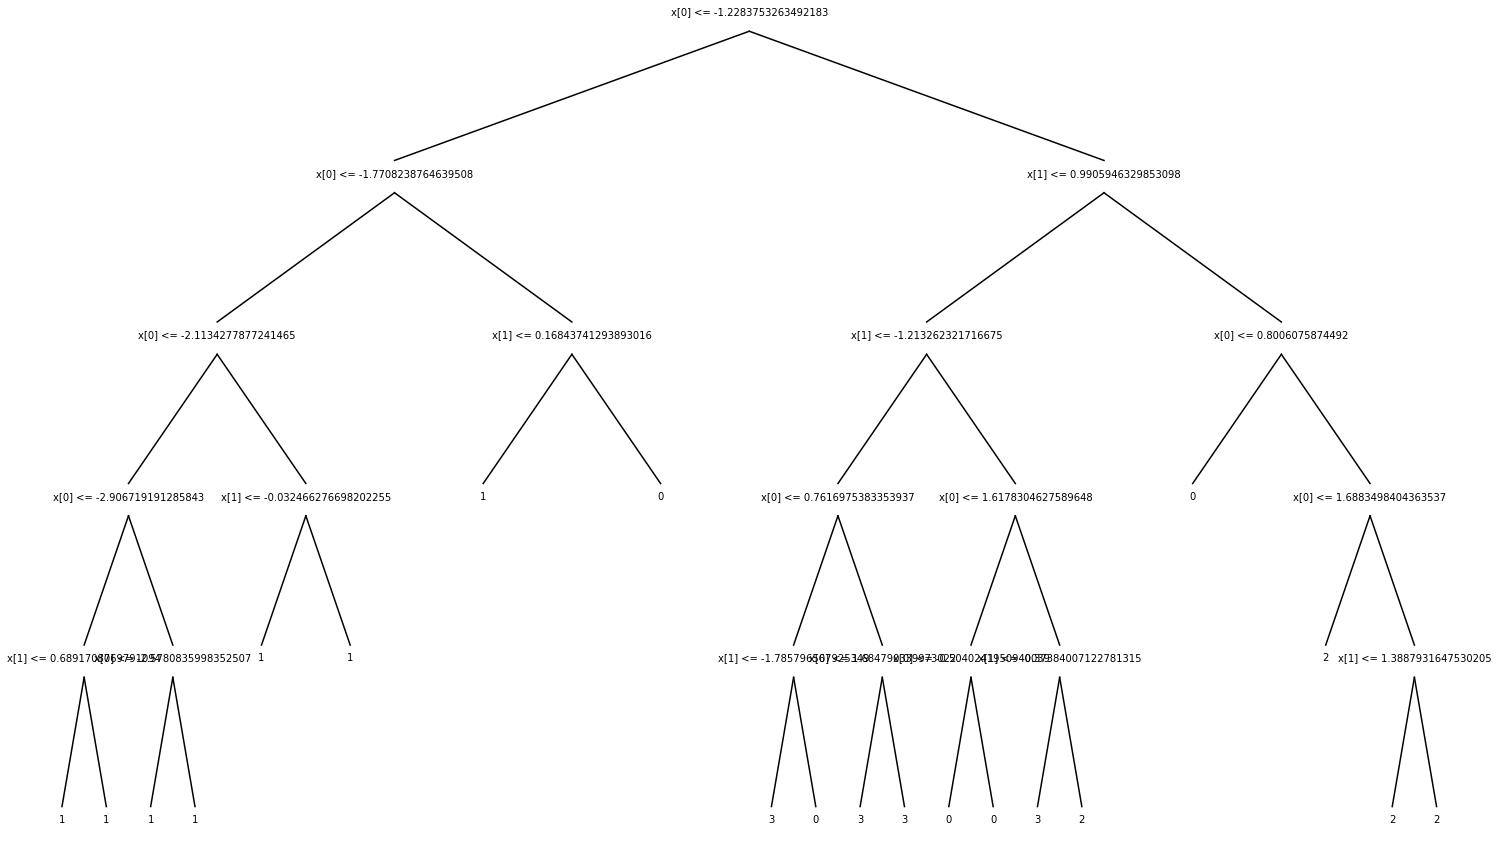

In [351]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [8]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=0)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

In [9]:
def train_test_split(X, y, ratio=0.9):
    l = round(ratio*len(X))
    return X[:l], y[:l], X[l:], y[l:] 
def train_test_validate_split(X, y, ratio=0.8):
    l = round(ratio*len(X))
    X_train, y_train, X_test, y_test = train_test_split(X, y, ratio)
    ll = len(X_test) // 2
    return X_train, y_train, X_test[:ll], y_test[:ll], X_test[ll:], y_test[ll:]

In [10]:
def accuracy(des_tree, X_test, y_test):
    y_pred = des_tree.predict(X_test)
    cor = len([1 for i in zip(y_pred, y_test) if i[0] == i[1]])
    return cor/len(y_test)

In [23]:
def test(X, y):
    leafs = np.arange(5, 41, 1)
    ds = [4, 5, 6]
    ans = dict()
    f = open("log.txt", "w")
    for leaf in leafs:
        f.write(f"current leaf - {leaf}\n")
        for d in ds:
            ans[leaf, d] = 0
            for j in range(10):
                X_train, y_train, X_val, y_val = train_test_split(X, y)
                f.write(f"\tcurrent depth - {d}\n")
                dtc = DecisionTreeClassifier(max_depth=d, min_samples_leaf=leaf)
                dtc.fit(X_train, y_train)
                ans[leaf, d] += accuracy(dtc, X_val, y_val) / 10 
                f.write("---------\n")
    return ans

In [ ]:
res = test(X, y)
max(res, key=res.get)

In [30]:
X, y = read_dataset("train.csv")
# X_train, y_train, X_test, y_test = train_test_split(X, y)
cols = pandas.read_csv("train.csv", header=0)
cols2 = np.array(['monster kills pd', 
                  'death in pvp %',
                  'player kills pd',
                  'accuracy'])
cols = cols.columns.tolist()[1:]
dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=20, criterion="gini")
dtc.fit(X, y)

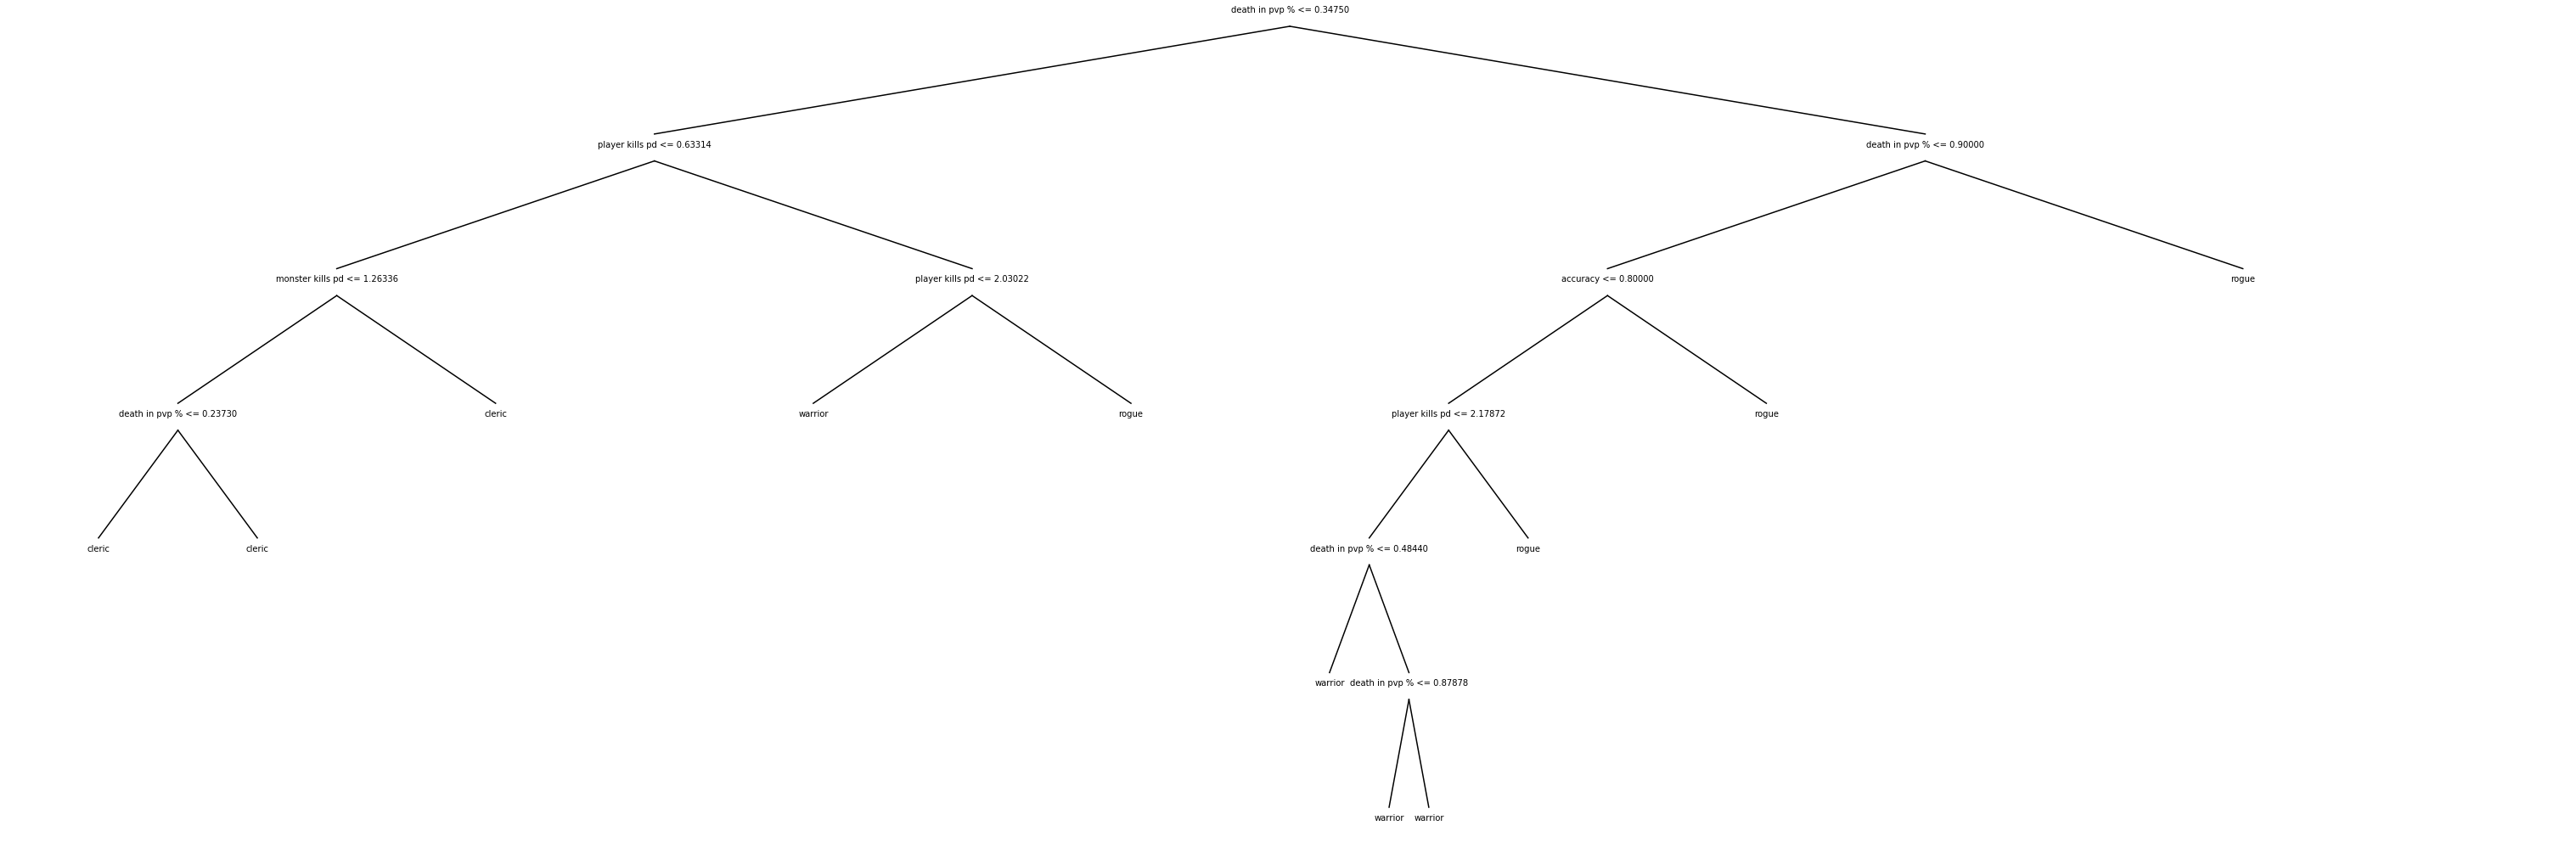

In [33]:
draw_tree(dtc, "cls", cols2)

### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс. 

In [421]:
def make_explanation(history):
    lb = [None]*4
    ub = [None]*4
    for ev in history:
        if ev[2] == 'l':
            if ub[ev[0]] is None or ub[ev[0]] > ev[1]:
                ub[ev[0]] = ev[1]
        else:
            if lb[ev[0]] is None or lb[ev[0]] < ev[1]:
                lb[ev[0]] = ev[1]
    res = "We think that it is your class because you have:"
    for i in range(4):
        if lb[i] is not None and ub[i] is not None:
            res += f"\n\t\t-{cols[i]} less then {ub[i]:.4f} and greater than {lb[i]:.4f}"
        elif lb[i] is not None:
            res += f"\n\t\t-{cols[i]} greater than {lb[i]:.4f}" 
        elif ub[i] is not None:
            res += f"\n\t\t-{cols[i]} less than {ub[i]:.4f}" 
    return res

In [422]:
def predict_explain(dtc, X):
    classs, hist = dtc.predict(X_test, full_res=True)
    expl = [make_explanation(h) for h in hist]
    return zip(classs, expl)

In [423]:
X, y = read_dataset("train.csv")
for pred_y, expl in predict_explain(dtc, X[:20]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: warrior
Explanation: We think that it is your class because you have:
		-death in pvp percentage less then 0.4003 and greater than 0.3302
		-player kills per death less than 2.4914
		-accuracy less than 0.8000

Class: rogue
Explanation: We think that it is your class because you have:
		-death in pvp percentage greater than 0.9000

Class: warrior
Explanation: We think that it is your class because you have:
		-death in pvp percentage less then 0.8788 and greater than 0.4003
		-player kills per death less than 2.4914
		-accuracy less than 0.8000

Class: warrior
Explanation: We think that it is your class because you have:
		-death in pvp percentage less then 0.9000 and greater than 0.8788
		-player kills per death less than 2.4914
		-accuracy less than 0.8000

Class: rogue
Explanation: We think that it is your class because you have:
		-death in pvp percentage greater than 0.9000

Class: cleric
Explanation: We think that it is your class because you have:
		-monster kills per dea